## 데이터셋 불러오기

In [4]:
# 행 축소 없이 다 보기
import pandas as pd
pd.set_option("display.max_rows", None)

In [5]:
master_data_df = pd.read_csv("../blinkit-dataset/blinkit_master_data_eda_mk_251224.csv")

In [6]:
master_data_df.columns

Index(['order_id', 'customer_id', 'order_date', 'promised_delivery_time',
       'actual_delivery_time', 'delivery_status', 'order_total',
       'payment_method', 'delivery_partner_id', 'store_id', 'product_id',
       'quantity', 'unit_price', 'product_name', 'category', 'brand', 'price',
       'mrp', 'margin_percentage', 'shelf_life_days', 'min_stock_level',
       'max_stock_level', 'delivery_time_minutes', 'distance_km',
       'reasons_if_delayed', 'feedback_id', 'rating', 'feedback_text',
       'feedback_category', 'sentiment', 'feedback_date', 'customer_name',
       'email', 'phone', 'address', 'area', 'pincode', 'registration_date',
       'customer_segment', 'total_orders', 'avg_order_value'],
      dtype='object')

---

### 가장 많이 주문된 카테고리 Top 5 찾기

In [7]:
top_categories = (
    master_data_df
    .groupby("category")["quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

top_categories

category
Dairy & Breakfast      1114
Household Care         1078
Pet Care               1003
Pharmacy                973
Fruits & Vegetables     966
Name: quantity, dtype: int64

### 시간 단위로 집계(일 단위)

In [8]:
category_df = master_data_df[
    master_data_df["category"] == "Dairy"
].copy()

category_df["order_date"] = pd.to_datetime(category_df["order_date"])

daily_demand = (
    category_df
    .groupby("order_date")["quantity"]
    .sum()
    .reset_index()
)

daily_demand

,order_date,quantity


In [9]:
master_data_df['order_date'].dtype

dtype('O')

### 카테고리 필터링

In [10]:
df_dairy = master_data_df[
    master_data_df['category'] == "Dairy & Breakfast"
].copy() # master_data_df의 category 컬럼을 복사해서 df_dairy로 재구성

df_dairy["order_date"] = pd.to_datetime(df_dairy["order_date"]) # datetime으로 타입 변환

In [11]:
df_dairy['order_date'].dtype

dtype('<M8[ns]')

### 일별 수요 데이터 생성

수요 예측에서 모델이 학습하는 내용:
1. “어제/지난주/지난달에
2. 이 카테고리가 얼마나 팔렸는지 →
(예측) 다음에 얼마나 팔릴까?”

그래서 👉 날짜 단위 수요만 남겨야 함

In [12]:
daily_demand = (
    df_dairy
    .groupby("order_date")["quantity"]
    .sum()
    .reset_index()
    .rename(columns={"quantity": "daily_quantity"})
)

daily_demand.head()

,order_date,daily_quantity
0,2023-03-16,1
1,2023-03-19,6
2,2023-03-23,3
3,2023-03-25,5
4,2023-03-26,2


---

### 일별 수요 시계열 그래프

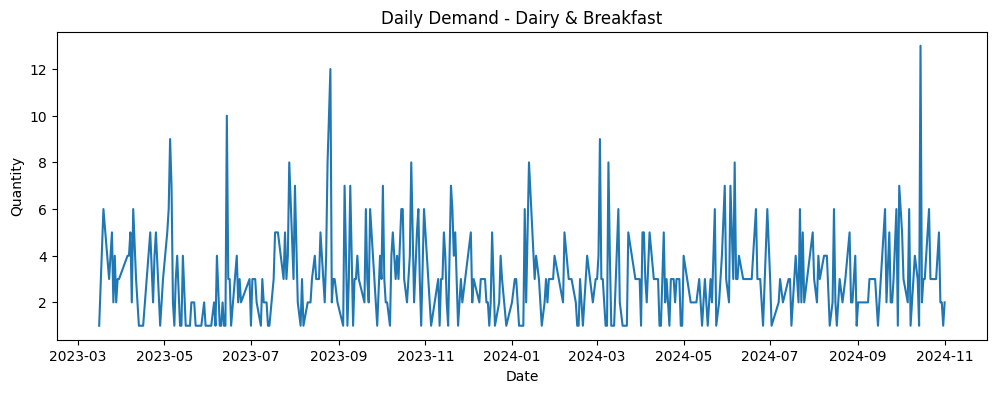

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(daily_demand["order_date"], daily_demand["daily_quantity"])
plt.title("Daily Demand - Dairy & Breakfast")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()

위 그래프에서 보는 포인트:  
- 전반적인 추세
- 갑자기 튀는 날 있는지
- 데이터 비어 보이는 구간

---

### lag/rolling feature 만들기(모델 입력용)